In [2]:
import os, sys, json
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("..")
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# read from json
data = None
data_path = "../../../output/prioplus-eurosys25/experiments/"
experiment_name = "fig3c"
with open(data_path + experiment_name + ".json", "r") as f:
    data = json.load(f)

In [4]:
# In this experiment, we have four flows and a bottleneck link
# Draw the send rate of each flow in subfigure1
# And draw the queue length of the bottleneck link in subfigure2

# Calculate the send rate from data{flowStatistics:[]:sentPkt:[timeNs,sizeByte]}
# The send rate is calculated by the number Bytes sent in each time interval
send_rate_interval_ns = 10e4  # 10us
send_rate = []
# calculate the total send rate of first 300 flows and the last flows

flow_num = 300
send_rate.append([])
wnd_start = data["flowStatistics"][0]["sentPkt"][0]["timeNs"]
# the first point
send_rate[0].append({"timeNs": wnd_start, "sendRateGbps": 0})
wnd_data = 0
pkt_idxs = [0 for _ in range(flow_num)]
while True:
    wnd_data = 0
    next_wnd_start = wnd_start + send_rate_interval_ns
    for i in range(flow_num):
        pkt_idx = 0
        for pkt_idx in range(pkt_idxs[i], len(data["flowStatistics"][i]["sentPkt"])):
            sentPkt = data["flowStatistics"][i]["sentPkt"][pkt_idx]
            if sentPkt["timeNs"] - wnd_start > send_rate_interval_ns:
                # Gbps = bpns
                # pkt_idxs[i] = pkt_idx - 1
                break
            wnd_data += sentPkt["sizeByte"]
        pkt_idxs[i] = pkt_idx
    send_rate[0].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                         "sendRateGbps": wnd_data * 8 / send_rate_interval_ns})
    wnd_start = next_wnd_start

    should_break = True
    for i in range(flow_num):
        if pkt_idxs[i] < len(data["flowStatistics"][i]["sentPkt"]) - 1:
            should_break = False
            break
    if should_break:
        break
# the last point
send_rate[0].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                     "sendRateGbps": 0})

high_flow_idx = flow_num
# the high prio flow
send_rate.append([])
wnd_start = data["flowStatistics"][high_flow_idx]["sentPkt"][0]["timeNs"]
# the first point
send_rate[1].append({"timeNs": wnd_start, "sendRateGbps": 0})
wnd_data = 0
for sentPkt in data["flowStatistics"][high_flow_idx]["sentPkt"]:
    if sentPkt["timeNs"] - wnd_start > send_rate_interval_ns:
        # Gbps = bpns
        send_rate[1].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                            "sendRateGbps": wnd_data * 8 / send_rate_interval_ns})
        wnd_start = sentPkt["timeNs"]
        wnd_data = 0
    wnd_data += sentPkt["sizeByte"]
# the last point
send_rate[1].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                        "sendRateGbps": 0})

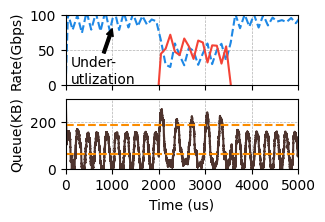

In [5]:
# draw the send rate in a new figure
fig = plt.figure(figsize=(3, 2))
ax1 = fig.add_subplot(211)
# ax.set_xlabel("Time (us)")
ax1.set_ylabel("Rate(Gbps)")

legend_lines = []

color_rate = ["#F44336", "#1E88E5"]
idx = {
    0: 1,
    1: 0
}
color_queue = ["#4E342E", "#FB8C00"]
line_style = ["-", "--"]

time_shift = 100e3
for i in [0, 1]:
    line = ax1.plot([s["timeNs"]/1e3 - time_shift for s in send_rate[i]], [s["sendRateGbps"]
                                                                               for s in send_rate[i]], label="flow"+str(i), color=color_rate[idx[i]], linestyle=line_style[idx[i]])
    legend_lines.append(line[0])
ax1.grid(True, linestyle='--', linewidth=0.5, which='both', axis='both')
ax1.set_xlim(0, 5000)
ax1.set_ylim(0, 100)
# hide x-axis label and ticks
ax1.xaxis.set_tick_params(labelbottom=False)

ax1.annotate('Under-\nutlization', xy=(1000, 80), xytext=(-30, -39),
            xycoords='data', textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0, width=2, headlength=5, headwidth=5),
            )

ax2 = fig.add_subplot(212)
ax2.set_xlabel("Time (us)")
ax2.set_ylabel("Queue(KB)")
# time_shift = 100e3 + 10
switch_idx = 0
port_idx = 0
queue_idx = 0
line = ax2.plot([q["timeNs"]/1e3 - time_shift for q in data["switchStatistics"][switch_idx]["portStats"][port_idx]["queueStats"][queue_idx]["qLength"]],
                [q["lengthBytes"] / 1024 for q in data["switchStatistics"][switch_idx]["portStats"][port_idx]["queueStats"][queue_idx]["qLength"]], label="Queue Length", color=color_queue[0], linestyle=line_style[0])
legend_lines.append(line[0])
ax2.hlines(62.5, 0, 6000, colors=color_queue[1], linestyles='--')
ax2.hlines(187.5, 0, 6000, colors=color_queue[1], linestyles='--')
# line = ax2.plot([t["timeNs"]/1e3 - time_shift for t in data["flowStatistics"][0]["ccStats"]["targetDelay"]],
#                 [target_to_queue(t["targetDelayNs"])/1024 for t in data["flowStatistics"][0]["ccStats"]["targetDelay"]], label="flow0 target delay", color=color_queue[1], linestyle=line_style[1])
# legend_lines.append(line[0])

# ax.axhline(y=400, color='r', linestyle='--', label="ECN Threshold")
ax2.grid(True, linestyle='--', linewidth=0.5, which='both', axis='both')
ax2.set_xlim(0, 5000)
ax2.set_ylim(0, 300)

# save as eps
plt.savefig("../figures/" + "fig3c" +
             ".pdf", bbox_inches='tight', dpi=600, format='pdf')